In [ ]:
# 구글 코랩 환경에서 사용 시 실행행
!sudo apt-get update && sudo apt-get install cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!git clone https://github.com/AI4Finance-Foundation/FinRL.git
!git clone https://github.com/AI4Finance-Foundation/FinRL-Tutorials.git
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install swig
!pip install wrds
!pip install pyportfolioopt
!pip install finrl
!pip install quantstats
!pip install torch
!pip install torch_geometric
!pip install optuna

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [66.7 kB]
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,309 kB]
Get:13 https://r2u.stat.illinois.e

In [ ]:
# import google
# from google.colab import files
# # files.upload()

import warnings

# FutureWarning을 무시
warnings.simplefilter(action='ignore', category=FutureWarning)

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import torch

import numpy as np
import pandas as pd

from sklearn.preprocessing import MaxAbsScaler
import sys
sys.path.append('/content/FinRL/finrl/meta/preprocessor')
# sys.path.append('/content/new_algorithms.py')
# sys.path.append('/content/new_models.py')
# from new_algorithms import PolicyGradient
# from new_models import DRLAgent
import preprocessors as pp

from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

In [ ]:
# ----------------------------
# 1. 데이터 불러오기 및 전처리
# ----------------------------

# 모델 학습에 사용할 장치 선택
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# 데이터 불러오기

# data = pd.read_excel("C:/Users/daily/Desktop/sampledata.xlsx")
# from google.colab import files
# files.upload()

df_portfolio = pd.read_excel('월별통합데이터1.xlsx')

# Symbol(회사 코드) 별로 그룹화
df_portfolio.groupby("Symbol Name").count()

# # GroupByScaler 수행 시 '날짜' 타입이 datetime이면 오류 발생, object로 변경
# data["time"] = data["time"].astype(object)
# # 수정주가 데이터가 0 (결측치)인 데이터 제거
# data = data.loc[data["수정주가 (현금배당반영)(원)"] != 0]

# GroupByScaler = Symbol을 기준(by = "Symbol")으로 data의 그룹화 후 처리(scaler) 진행
# MaxAbsScaler = 주어진 데이터 값을 [-1, 1]로 변환, 최댓값의 절댓값을 기준으로 변환
# portfolio_norm_df = pp.GroupByScaler(by="Symbol Name", scaler=MaxAbsScaler).fit_transform(data)
# portfolio_norm_df

# portfolio_norm_df에서 해당 열을 추출하여 df_portfolio에 할당
# df_portfolio = data[["Symbol Name", "time", "수정주가 (현금배당반영)(원)", "시가총액 (KRX)(원)", "*총금융부채(원)",
#                                   "단기금융부채(원)", "단기금융자산(원)", "당기순이익(원)", "당좌자산(원)", "매출액(원)",
#                                   "매출채권(원)", "무형자산(원)", "비유동부채(원)", "비유동자산(원)", "영업이익(원)", "유동부채(원)",
#                                   "유동자산(원)", "유형자산(원)", "장기금융부채(원)", "재고자산(원)", "총부채(원)", "총자본(원)", "총자산(원)",
#                                   "총포괄이익(원)", "현금및현금성자산(원)", "DDR3 4Gb 512Mx8 eTT(USD)", "DDR4 16G (2G*8) eTT MHZ(USD)",
#                                   "국채금리_미국국채(10년)(%)", "국채금리_미국국채(1년)(%)", "금(선물)($/ounce)", "니켈(선물)($/ton)",
#                                   "시장금리:CD유통수익률(91)(%)", "시장금리:국고10년(%)", "시장금리:회사채(무보증3년AA-)(%)",
#                                   "시장평균_미국(달러)(통화대원)", "시장평균_일본(100엔)((100)통화대원)", "시장평균_중국(위안)(통화대원)",
#                                   "주요상품선물_DUBAI(ASIA1M)($/bbl)", "주요상품선물_소맥(최근월물)(￠/bu)", "주요상품선물_전기동(선물)($/ton)",
#                                   "당기순이익(-)", "영업이익(-)", "총포괄이익(-)"]]
# # 날짜에 따른 분할을 수행하기 위해 '날짜'를 다시 datetime 타입으로 변환
df_portfolio["time"] = df_portfolio["time"].astype('datetime64[ns]')

sptdate = "2020-04-01"

# 학습 데이터와 테스트 데이터를 date 기준에 따라 분할
df_portfolio_train = df_portfolio[(df_portfolio["time"] < sptdate)]
df_portfolio_test = df_portfolio[(df_portfolio["time"] >= sptdate)]

# 2017년 전 데이터가 존재하는 symbol name을 train_list에 저장
# train_list = df_portfolio[df_portfolio['time'] < '2017-01-01']['Symbol Name'].unique()
# train_list에 해당하는 데이터만 추출하여 train_data로 저장
# df_portfolio_train = df_portfolio[df_portfolio['Symbol Name'].isin(train_list)]

# # train, test 데이터셋 분리
# df_portfolio_train = df_portfolio_train[(df_portfolio_train["time"] >= "2010-01-01") & (df_portfolio_train["time"] < "2019-01-01")]
# df_portfolio_test = df_portfolio[(df_portfolio["time"] >= "2019-01-01") & (df_portfolio["time"] < "2025-01-01")]

Saving 월별통합데이터1_1.xlsx to 월별통합데이터1_1.xlsx


In [ ]:
# -------------------------------------------
# 2. 파라미터 튜닝을 위한 모델 학습 환경 설정
# -------------------------------------------

'''
df_portfolio_train = 학습할 데이터
initial_amount = 초기 자본금
comission_fee_pct = 거래 수수료 퍼센트
time_window = 학습할 과거 일수를 설정 -> n일간의 주식 가격 데이터 기반 포트폴리오 관리
features = 학습할 특성 지정
tic_column = 그룹화 기준이 되는 범주형 변수
time_column = 시간 변수 지정
valuation_feature = 포트폴리오를 평가할 기준이 될 변수 지정
normalize_df = 정규화 진행 설정 (None = 정규화 X / MinMaxScaler / StandardScaler)
'''
features = ["수정주가 (현금배당반영)(원)", "시가총액 (KRX)(원)", "*총금융부채(원)",
                                   "단기금융부채(원)", "단기금융자산(원)", "당기순이익(원)", "당좌자산(원)", "매출액(원)",
                                   "매출채권(원)", "무형자산(원)", "비유동부채(원)", "비유동자산(원)", "영업이익(원)", "유동부채(원)",
                                   "유동자산(원)", "유형자산(원)", "장기금융부채(원)", "재고자산(원)", "총부채(원)", "총자본(원)", "총자산(원)",
                                   "총포괄이익(원)", "현금및현금성자산(원)", "DDR3 4Gb 512Mx8 eTT(USD)", "DDR4 16G (2G*8) eTT MHZ(USD)",
                                   "국채금리_미국국채(10년)(%)", "국채금리_미국국채(1년)(%)", "금(선물)($/ounce)", "니켈(선물)($/ton)",
                                   "시장금리:CD유통수익률(91)(%)", "시장금리:국고10년(%)", "시장금리:회사채(무보증3년AA-)(%)",
                                   "시장평균_미국(달러)(통화대원)", "시장평균_일본(100엔)((100)통화대원)", "시장평균_중국(위안)(통화대원)",
                                   "주요상품선물_DUBAI(ASIA1M)($/bbl)", "주요상품선물_소맥(최근월물)(￠/bu)", "주요상품선물_전기동(선물)($/ton)",
                                   "당기순이익(-)", "영업이익(-)", "총포괄이익(-)"]

initial_features = len(features)

timewin = 24
ksize = 12
fee = 0.0012


environment_train = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=fee,
        time_window=timewin,
        features= features,
        tic_column="Symbol Name",
        time_column="time",
        valuation_feature="수정주가 (현금배당반영)(원)",
        normalize_df=None,
        cwd= '/content'
    )

agent = DRLAgent(environment_train)

In [ ]:
# ----------------------
# 3. 하이퍼파라미터 튜닝
# ----------------------
import pandas as pd
import numpy as np
import optuna
import joblib
import quantstats as qs

# 실험 횟수 설정 (하이퍼파라미터를 탐색하여 모델을 훈련시킬 횟수)
num_trial = 100

# 훈련 횟수 설정 (한 실험 당 모델이 훈련 사이클을 얼마나 진행할 지)
num_episode = 100


# 설정할 하이퍼파라미터 설정
def sample_pg_params(trial:optuna.Trial):
  '''
  learning_rate : 학습률을 1e-5 ~ 1 사이에서 탐색
  k_size : 커널 사이즈를 리스트 내 값들 중에서 탐색
  batch_size : 배치 사이즈를 리스트 내 값들 중에서 탐색
  action_noise : 행동에 노이즈를 추가하여 모델이 행동을 선택할 때 더 새로운 선택을 할 수 있도록 조정
  '''
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1)
  k_size = trial.suggest_categorical("k_size", [3, 5, 7])
  batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256, 512])
  action_noise = trial.suggest_loguniform("action_noise", 1e-3, 1)


  return {"lr":learning_rate,
          "k_size":k_size,
          "batch_size":batch_size,
          "action_noise":action_noise}



from IPython.display import clear_output
import os

os.makedirs("models",exist_ok=True)

def objective(trial:optuna.Trial):
  # Trial will suggest a set of hyperparamters from the specified range
  hyperparameters = sample_pg_params(trial)

  # 강화학습 모델(PolicyGradient)의 파라미터
  model_kwargs = {
    "lr": hyperparameters['lr'],
    "policy": EIIE,
    "batch_size": hyperparameters['batch_size'],
    "action_noise": hyperparameters['action_noise']
  }

  # 정책 신경망(EIIE)의 파라미터
  policy_kwargs = {
    "k_size": hyperparameters['k_size'],
    "time_window": timewin,
    "initial_features" : initial_features
  }

  # 모델 선언
  model_pg = agent.get_model("pg", device, model_kwargs = model_kwargs, policy_kwargs=policy_kwargs)

  # 하이퍼파라미터 튜닝 시 사용할 모델 훈련
  trained_pg = agent.train_model(model_pg, episodes=num_episode)
  # 훈련 결과를 저장
  torch.save(trained_pg.train_policy.state_dict(), "models/pg_{}.pt".format(trial.number))
  clear_output(wait=True)

  # 훈련된 모델을 사용, 검증을 통해 샤프 비율을 계산
  DRLAgent.DRL_validation(
      model=trained_pg,
      test_env=environment_train)

  # 샤프 비율을 계산
  # 하이퍼파라미터를 튜닝하는데 기준이 되는 값
  '''
  date : 각 시점의 날짜
  returns : 각 시점 별 포트폴리오 수익률
  rewards : 각 시점 별 보상값
  portfolio_values : 각 시점 별 포트폴리오 자산
  '''
  value_df = pd.DataFrame(
                {
                    "date": environment_train._date_memory,
                    "returns": environment_train._portfolio_return_memory,
                    "rewards": environment_train._portfolio_reward_memory,
                    "portfolio_values": environment_train._asset_memory["final"],
                }
            )
  # value_df의 인덱스를 date로 지정
  value_df.set_index("date", inplace=True)

  # 샤프 비율 계산
  sharpe_value = qs.stats.sharpe(value_df["returns"])

  return sharpe_value


#
class LoggingCallback:
    def __init__(self, threshold, trial_number, patience):
      '''
      threshold : 목표값(샤프 비율)의 변화가 threshold보다 작을 시 학습 종료
      trial_number : 튜닝 횟수 설정
      patience : threshold 변화 없음 상태가 patience 횟수만큼 반복될 시 학습 종료료
      '''
      self.threshold = threshold
      self.trial_number  = trial_number
      self.patience = patience
      self.cb_list = [] # threshold 조건을 충족한 실험(trial) 번호를 기록

    # 매 실험(trial)마다 호출
    def __call__(self, study:optuna.study, frozen_trial:optuna.Trial):
      #Setting the best value in the current trial
      study.set_user_attr("previous_best_value", study.best_value)

      # 최소 시도 횟수를 통과했는지 비교
      if frozen_trial.number > self.trial_number:
          # 이전 실험의 베스트 케이스를 저장
          previous_best_value = study.user_attrs.get("previous_best_value",None)

          # 이전과 현재의 베스트 케이스가 같은 부호인지 판별 (파라미터 조정을 통해 목표(샤프 비율)이 개선되었는지 확인)
          if previous_best_value * study.best_value >=0:
              # 목표 값의 차이가 threshold보다 작은지 확인 (의미있는 개선이 되는지 확인)
              if abs(previous_best_value-study.best_value) < self.threshold:
                  self.cb_list.append(frozen_trial.number)
                  # threshold 기준값을 넘지 못한 횟수가 patience번 반복되었는지 확인
                  if len(self.cb_list) > self.patience:
                      print('The study stops now...')
                      print('With number',frozen_trial.number ,'and value ',frozen_trial.value)
                      print('The previous and current best values are {} and {} respectively'
                              .format(previous_best_value, study.best_value))
                      study.stop()


# 하이퍼파라미터 탐색 알고리즘
# seed=42 : 매번 동일한 난수를 생성하도록 설정하여 결과가 재현될 수 있도록 함
sampler = optuna.samplers.TPESampler(seed=42)

# 하이퍼파라미터 탐색 환경 선언
'''
study_name : 탐색 환경 이름 설정
direction : 'maximize' = 목표 함수(샤프 비율)을 최대화하는 방향으로 학습 진행
sampler : 탐색 알고리즘 설정
pruner : 하이퍼밴드 알고리즘을 기반, 중간에 성능이 좋지 않은 실험을 조기에 종료
'''
study = optuna.create_study(study_name="pg_study",direction='maximize',
                            sampler = sampler, pruner=optuna.pruners.HyperbandPruner())

# 위에서 선언된 Loggingcallback 함수 설정
logging_callback = LoggingCallback(threshold=1e-5, patience=30, trial_number=num_trial)

# 하이퍼파라미터 튜닝 시작
'''
objective = 목표 함수
n_traials = 최대 실험 진행 횟수 설정
callbacks = 조건 충족 시 최적화를 조기에 중지
'''
study.optimize(objective, n_trials=num_trial, callbacks=[logging_callback])

# study 객체를 파일로 저장
joblib.dump(study, "final_pg_study__.pkl")


# 튜닝된 하이퍼파라미터를 출력
best_lr = study.best_params['lr']
best_k_size = study.best_params['k_size']
best_batch_size = study.best_params['batch_size']
best_action_noise = study.best_params['action_noise']

print('\nHyperparameters after tuning')
print('Best learning rate :', best_lr)
print('Best kernel size :', best_k_size)
print('Best batch size :', best_batch_size)
print("Best action noise:", best_action_noise)
print("Sharpe Ratio of Best Trial :", *study.best_trial.values)

Initial portfolio value:100000
Final portfolio value: 93715.6484375
Final accumulative portfolio value: 0.937156484375
Maximum DrawDown: -0.275162821848993
Sharpe ratio: -0.17905638319615388


[I 2025-02-08 17:48:25,301] Trial 0 finished with value: -0.17905638319615388 and parameters: {'lr': 0.0007459343285726547, 'k_size': 3, 'batch_size': 256, 'action_noise': 0.13311216080736885}. Best is trial 0 with value: -0.17905638319615388.



Hyperparameters after tuning
Best learning rate : 0.0007459343285726547
Best kernel size : 3
Best batch size : 256
Best action noise: 0.13311216080736885
Sharpe Ratio of Best Trial : -0.17905638319615388


In [ ]:
# --------------------
# 3. 모델 설정 및 학습
# --------------------

'''
DRLAgent = 강화학습 모델 훈련 객체
"pg" = 강화학습 모델 PolicyGradient
device = 학습을 수행할 장치 지정 (cpu, gpu)
model_kwargs = 강화학습 모델 파라미터
policy_kwargs = 정책 신경망 파라미터
'''

# 강화학습 모델 파라미터 설정
model_kwargs = {
    "lr": best_lr,
    "policy": EIIE,
    "batch_size": best_batch_size,
    "action_noise": best_action_noise
  }

# 정책 신경망(EIIE)의 파라미터 설정
policy_kwargs = {
    "k_size": best_k_size,
    "time_window": timewin,
    "initial_features" : initial_features
  }

model = DRLAgent(environment_train).get_model("pg", device, model_kwargs, policy_kwargs)

# 설정한 모델 훈련
'''
model = 위에서 지정한 강화학습 모델
episodes = 학습 횟수 (epoch와 같은 의미)
'''
DRLAgent.train_model(model, episodes=100)

# 훈련된 정책 네트워크를 policy_EIIE.pt로 저장
torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

# ----------------------------------
# 4. 테스트 환경 설정 및 테스트 진행
# ----------------------------------

'''
df_portfolio_train = 학습할 데이터
initial_amount = 초기 자본금
comission_fee_pct = 거래 수수료 퍼센트
time_window = 학습할 과거 일수를 설정 -> n일간의 주식 가격 데이터 기반 포트폴리오 관리
features = 학습할 특성 지정
tic_column = 그룹화 기준이 되는 범주형 변수
time_column = 시간 변수 지정
valuation_feature = 포트폴리오를 평가할 기준이 될 변수 지정
normalize_df = 정규화 진행 설정 (None = 정규화 X / MinMaxScaler / StandardScaler)
'''
environment_test = PortfolioOptimizationEnv(
    df_portfolio_test,
    initial_amount=100000,
    comission_fee_pct=fee,
    time_window=timewin,
    features=features,
    tic_column="Symbol Name",
    time_column="time",
    valuation_feature="수정주가 (현금배당반영)(원)",
    normalize_df=None,
    cwd='/content'
)


EIIE_results = {
    "training": {},
    "test": {},
}


EIIE_results["training"]["value"] = environment_train._asset_memory["final"]
EIIE_results["training"]["weights"] = environment_train._final_weights

# 정책 신경망 설정
'''
time_window = 과거 n일의 데이터를 학습
device = 학습을 수행할 장치 선택
initial_features = 입력 변수의 개수 설정
'''
policy = EIIE(time_window=timewin, device=device, initial_features=initial_features, k_size=best_k_size)
# 저장되어있는 EIIE의 파라미터를 불러옴
policy.load_state_dict(torch.load("policy_EIIE.pt"))

# 모델의 성능 평가 후 최종 가치를 EIIE result에 저장
'''
model = 강화학습 모델
environment_2012 = 위에서 정의한 테스트 환경
policy = 정책 신경망 설정
'''
DRLAgent.DRL_validation(model, environment_test, policy=policy)
#DRLAgent.DRL_validation(model, environment, policy=policy)

EIIE_results["test"]["value"] = environment_test._asset_memory["final"]
EIIE_results["test"]["weights"] = environment_test._final_weights

  0%|          | 0/1 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 120265.8671875
Final accumulative portfolio value: 1.202658671875
Maximum DrawDown: -0.04912946785947947
Sharpe ratio: 3.669218738228289


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]
<ipython-input-56-b724c028e49b>:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_EII

Initial portfolio value:100000
Final portfolio value: 99999.203125
Final accumulative portfolio value: 0.99999203125
Maximum DrawDown: -8.906244433615207e-06
Sharpe ratio: -2.6656054877248474


In [ ]:
# ---------------------------------------------------------------------
# 5. 강화학습 모델과의 성능 비교를 위해 Buy and hold 전략으로 학습 진행
# ---------------------------------------------------------------------

UBAH_results = {
    "train": {},
    "test": {}
}

# train 데이터의 회사 갯수를 TRAIN_PORTFOLIO_SIZE에 저장
train_symbol_list = list(set(df_portfolio_train['Symbol Name']))
TRAIN_PORTFOLIO_SIZE = len(train_symbol_list)

# test 데이터의 회사 갯수를 TEST_PORTFOLIO_SIZE에 저장
test_symbol_list = list(set(df_portfolio_test['Symbol Name']))
TEST_PORTFOLIO_SIZE = len(test_symbol_list)

# train 환경
'''
terminated = 학습 종료 시점을 알기 위한 변수
environment.reset() = 학습 환경 초기화
action = 포트폴리오에 대한 자산 배분 전략
        [0]: 첫 번째 자산(예: 현금)의 비율이 0으로 설정, 현금 자산에 대한 투자는 하지 않겠다는 뜻
        [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE: 나머지 자산에 대해서는 동일한 비율로 분배
        PORTFOLIO_SIZE는 자산의 수를 나타내므로, 각 자산에 대해 동일한 비율인 1/PORTFOLIO_SIZE만큼 배분
UBAH_results... = UBAH_results 딕셔너리에 최종 가치를 저장장
'''
terminated = False
environment_train.reset()

while not terminated:
    action = [0] + [1/TRAIN_PORTFOLIO_SIZE] * TRAIN_PORTFOLIO_SIZE
    _, _, terminated, _ = environment_train.step(action)
UBAH_results["train"]["value"] = environment_train._asset_memory["final"]
UBAH_results["train"]["weights"] = environment_train._final_weights

# 테스트 환경
terminated = False
environment_test.reset()
while not terminated:
    action = [0] + [1/TEST_PORTFOLIO_SIZE] * TEST_PORTFOLIO_SIZE
    _, _, terminated, _ = environment_test.step(action)
UBAH_results["test"]["value"] = environment_test._asset_memory["final"]
UBAH_results["test"]["weights"] = environment_test._final_weights

Initial portfolio value:100000
Final portfolio value: 92578.46875
Final accumulative portfolio value: 0.9257846875
Maximum DrawDown: -0.3029300593795501
Sharpe ratio: -0.1787579908938069
Initial portfolio value:100000
Final portfolio value: 106927.5078125
Final accumulative portfolio value: 1.069275078125
Maximum DrawDown: -0.21100422457575474
Sharpe ratio: 1.0003050774893738


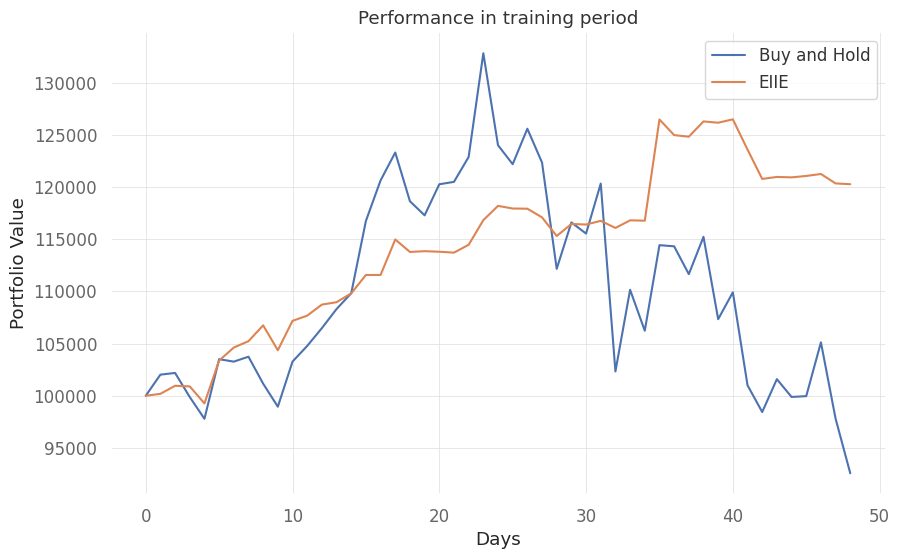

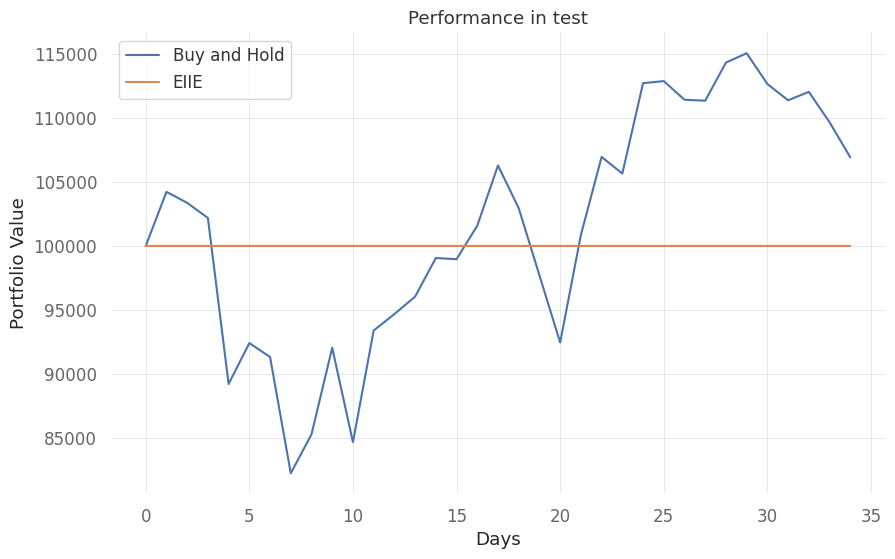

In [ ]:
# ---------
# 6. 시각화
# ---------

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

# 학습 환경(2011년)에서의 UBAH (Buy and Hold) 전략과 EIIE 전략의 최종 가치 비교
plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["training"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

# 테스트 환경(2012년)에서의 UBAH (Buy and Hold) 전략과 EIIE 전략의 최종 가치 비교
plt.plot(UBAH_results["test"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["test"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in test")
plt.legend()

plt.show()

In [ ]:
#  마지막 에피소드(=에포크)에 대한 값입니다.

# train 환경에서 학습이 진행된 모델 정보
print('\n        ----------------- 학습 환경 모델 정보 -----------------        \n')

# 포트폴리오 계산 시점
date_memory = environment_train._date_memory
# 시점 별 포트폴리오 수익률
return_memory = pd.DataFrame(environment_train._portfolio_return_memory).transpose()
# 시점 별 보상 가중치
reward_memory =  pd.DataFrame(environment_train._portfolio_reward_memory).transpose()
# 시점 별 행동 가중치
action_memory = pd.DataFrame(environment_train._actions_memory).transpose()
# 시점 별 포트폴리오 자산
asset_memory = pd.DataFrame(environment_train._asset_memory['final']).transpose()

str_list = ['return', 'asset', 'action', 'reward']
memory_list = [return_memory, asset_memory, action_memory, reward_memory]

for i in range(len(str_list)):
  df_result = pd.DataFrame(columns=date_memory)
  print('> {}.'.format(i), '{0} in train'.format(str_list[i]))
  for j in range(100):
    try:
      value = memory_list[i]
      df_result[date_memory[j]] = value[j]
    except:
      break
  print(df_result, "\n")




# test 환경에서 학습이 진행된 모델 정보
print('\n        ----------------- 테스트 환경 모델 정보 -----------------        \n')

# 포트폴리오 계산 시점
date_memory = environment_test._date_memory
# 시점 별 포트폴리오 수익률
return_memory = pd.DataFrame(environment_test._portfolio_return_memory).transpose()
# 시점 별 보상 가중치
reward_memory =  pd.DataFrame(environment_test._portfolio_reward_memory).transpose()
# 시점 별 행동 가중치
action_memory = pd.DataFrame(environment_test._actions_memory).transpose()
# 시점 별 포트폴리오 자산
asset_memory = pd.DataFrame(environment_test._asset_memory['final']).transpose()

str_list = ['return', 'asset', 'action', 'reward']
memory_list = [return_memory, asset_memory, action_memory, reward_memory]

for i in range(len(str_list)):
  df_result = pd.DataFrame(columns=date_memory)
  print('* {}.'.format(i), '{0} in test'.format(str_list[i]))
  for j in range(100):
    try:
      value = memory_list[i]
      df_result[date_memory[j]] = value[j]
    except:
      break
  print(df_result, "\n")


        ----------------- 학습 환경 모델 정보 -----------------        



NameError: name 'environment_train' is not defined